## **Detecting fraudulent transactions from transactional customer data using XGBoost-Hyperopt**
* ###  **Implementing Hyperparmeter Optimization with XGBoost to detect and classify fraudulent data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time

## Hyperparameter optimization modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

**Importing the data - (resampled data from the Class Imbalance notebook)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/MLE-UCSD/CAPSTONE_Extra-Projects/Credit Card Fraud Detection/Model Implementation/XGBoost HyperOpt Model/final_data/X_train_final.csv')
y_train = pd.read_csv('/content/drive/MyDrive/MLE-UCSD/CAPSTONE_Extra-Projects/Credit Card Fraud Detection/Model Implementation/XGBoost HyperOpt Model/final_data/y_train_final.csv')
X_test = pd.read_csv('/content/drive/MyDrive/MLE-UCSD/CAPSTONE_Extra-Projects/Credit Card Fraud Detection/Model Implementation/XGBoost HyperOpt Model/final_data/X_test_final.csv')

In [ ]:
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

**Reducing Memory Usage**

In [ ]:
from memory_reduction import reduce_mem_usage

X_train = reduce_mem_usage(X_train)
y_train = reduce_mem_usage(y_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 886.95 MB
Memory usage after optimization is: 226.09 MB
Decreased by 74.5%
Memory usage of dataframe is 9.78 MB
Memory usage after optimization is: 6.52 MB
Decreased by 33.3%
Memory usage of dataframe is 394.31 MB
Memory usage after optimization is: 93.74 MB
Decreased by 76.2%


**Setting and cleaning the train and test data**

In [ ]:
X_train.drop('Unnamed: 0',axis=1, inplace=True)
y_train.drop('Unnamed: 0',axis=1, inplace=True)
X_test.drop('Unnamed: 0',axis=1, inplace=True)

In [ ]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1139754, 101)
y_train shape:  (1139754, 1)
X_test shape:  (506691, 101)


In [ ]:
y_train = y_train['isFraud'].astype(bool)

# **XGBoost Classification with HyperOpt (best and final model)**
* ### **Hyperparameter Optimization**

In [ ]:
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time

## Hyperparameter optimization modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

### **Hyperparameterization function**

In [ ]:
def hyper_opt(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 4
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
  
        try:
            score = make_scorer(roc_auc_score, needs_proba= True)(clf, X_vl, y_vl)
        except ValueError:
            pass

        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


### **Optimizer Algorithm Parameters** 

In [ ]:
#from hyper_opt_function import parameters

parameters = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

## **Running the Optimizer**

In [ ]:
%time hyperOpt_best = fmin(fn = hyper_opt, space = parameters, algo = tpe.suggest, max_evals = 30) #check max_evals

best_parameters = space_eval(parameters, hyperOpt_best)


############## New Run ################
params = {'max_depth': 23, 'gamma': '0.242', 'subsample': '0.90', 'reg_alpha': '0.042', 'reg_lambda': '0.299', 'learning_rate': '0.022', 'num_leaves': '160.000', 'colsample_bytree': '0.406', 'min_child_samples': '150.000', 'feature_fraction': '0.765', 'bagging_fraction': '0.872'}
1 CV - score: 0.8997
2 CV - score: 0.9782
3 CV - score: 0.9782
4 CV - score: 0.9782
Total Time Run: 13.84
Mean ROC_AUC: 0.9586014275099253

############## New Run ################
params = {'max_depth': 9, 'gamma': '0.496', 'subsample': '0.50', 'reg_alpha': '0.052', 'reg_lambda': '0.039', 'learning_rate': '0.020', 'num_leaves': '170.000', 'colsample_bytree': '0.522', 'min_child_samples': '130.000', 'feature_fraction': '0.674', 'bagging_fraction': '0.816'}
1 CV - score: 0.899
2 CV - score: 0.9605
3 CV - score: 0.9605
4 CV - score: 0.9605
Total Time Run: 1.96
Mean ROC_AUC: 0.9451083744687256

############## New Run ################
params = {'max_depth': 20, 'gamma': '0.4

* ### **Best Parameters**

In [19]:
print("BEST HyperOpt PARAMS: ", best_parameters)

best_parameters['max_depth'] = int(best_parameters['max_depth'])

BEST HyperOpt PARAMS:  {'bagging_fraction': 0.8640269698956295, 'colsample_bytree': 0.6272318890888496, 'feature_fraction': 0.7268934896539098, 'gamma': 0.1681830124075458, 'learning_rate': 0.061478187605162056, 'max_depth': 23.0, 'min_child_samples': 210, 'num_leaves': 160, 'reg_alpha': 0.021504250452895467, 'reg_lambda': 0.2928109816202592, 'subsample': 0.9}


## **Implementing and Training XGBoost Model with HyperOpt parameters**

In [20]:
xgb_best = xgb.XGBClassifier(n_estimators=300, **best_parameters, tree_method='gpu_hist')
#xgb_best = xgboost.XGBClassifier(n_estimators=300, param_grid = best_parameters, tree_method='gpu_hist')

xgb_best.fit(X_train, y_train)

XGBClassifier(bagging_fraction=0.8640269698956295, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6272318890888496,
              feature_fraction=0.7268934896539098, gamma=0.1681830124075458,
              learning_rate=0.061478187605162056, max_delta_step=0,
              max_depth=23, min_child_samples=210, min_child_weight=1,
              missing=None, n_estimators=300, n_jobs=1, nthread=None,
              num_leaves=160, objective='binary:logistic', random_state=0,
              reg_alpha=0.021504250452895467, reg_lambda=0.2928109816202592,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.9,
              tree_method='gpu_hist', verbosity=1)

* ### **Predicting Presence of Fradulent Transactions for Test Set (X_test)**

In [21]:
y_pred = xgb_best.predict(X_test)
y_pred_proba = xgb_best.predict_proba(X_test)[:,1] 

## **Feature Importance Rankings and Visualization**

<Figure size 1080x576 with 0 Axes>

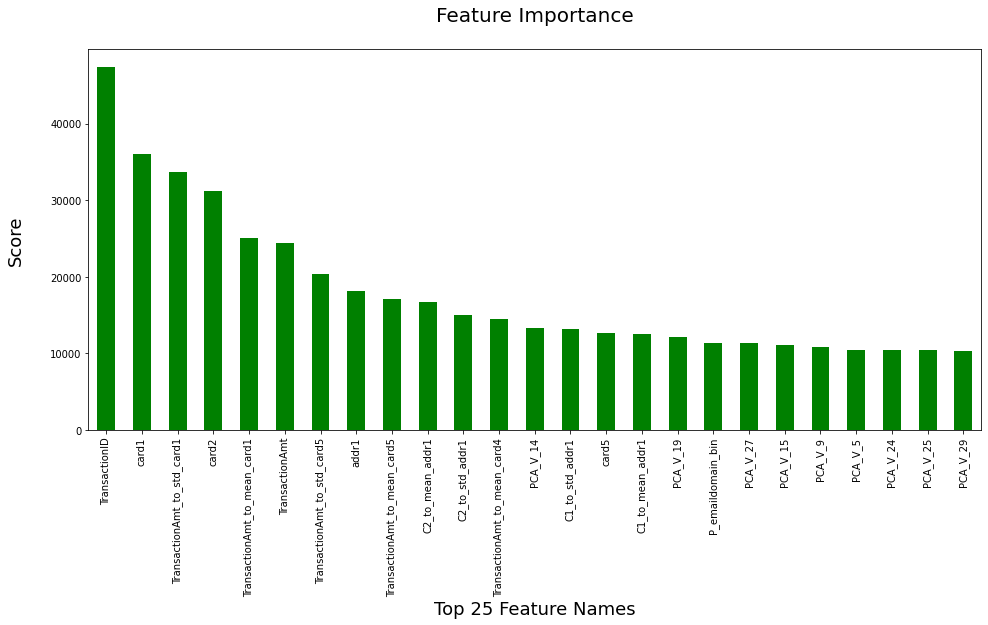

In [22]:
feature_important = xgb_best.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

plot_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plot_df.reset_index(inplace=True)
plot_df.columns = ['Feature Name', 'Score']
plot_df.sort_values('Score', ascending = False, inplace = True)
plot_df.set_index('Feature Name', inplace = True)

plt.figure(figsize = (15,8))

plot_df.iloc[:25].plot(kind = 'bar', legend = False, figsize = (16,7), color="g", align="center")
plt.title("Feature Importance\n", fontsize=20)
plt.xticks(fontsize = 10)
plt.xlabel('Top 25 Feature Names', fontsize=18)
plt.ylabel('Score\n', fontsize =18)
plt.show()


In [ ]:
sample_submission['isFraud'] = y_pred
sample_submission.set_index('TransactionID',inplace = True)

In [26]:
sample_submission.isFraud.value_counts()

False    497693
True       8998
Name: isFraud, dtype: int64

## **Saving the model**

In [33]:
import joblib 

joblib.dump(xgb_best, '../content/fraud-detection-hyperopt-model.pkl')

['../content/fraud-detection-hyperopt-model.pkl']